Libraries

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import time

TestBed Class

In [34]:
#TestBed class containing the states and actions, and the overall rules of the test
class Testbed(object):

    # Constructor
    def __init__(self, nArms, mean, stDev):
    
        self.nArms = nArms      # number of arms
        self.mean = mean        # Mean
        self.stDev = stDev      # Standard Deviation
        self.actArr = np.zeros(nArms)   # Array to store action values
        self.optim = 0                  # Store optimal value for greedy
        self.reset()

    # Reset testbed for next iteration
    def reset(self):
        self.actArr = np.random.normal(self.mean, self.stDev, self.nArms)
        self.optim = np.argmax(self.actArr)


Agent class

In [28]:
# Agent Class - Controls the agents movement and behaviour in the environment interacting with the testbed
# and receives information on the current position
class Agent(object):

    # Constructor with decay types: 'linear', 'exponential', or 'constant'
    def __init__(self, nArms, eProb=0, decay_type='constant', initial_epsilon=1.0, final_epsilon=0.01, decay_rate=0.001):
        self.nArms = nArms      # Number of arms
        self.eProb = eProb      # Initial epsilon probability for constant decay
        self.initial_epsilon = initial_epsilon
        self.final_epsilon = final_epsilon
        self.decay_rate = decay_rate
        self.decay_type = decay_type
        self.timeStep = 0
        self.lastAction = None
        self.kAction = np.zeros(nArms)   # count of actions taken at time t
        self.rSum = np.zeros(nArms)      # Sums number of rewards
        self.valEstimates = np.zeros(nArms)  # action value estimates sum(rewards)/Amount

    # Return string for graph legend
    def __str__(self):
        return f"{self.decay_type.capitalize()} Decay Epsilon"
#CHECK++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # Linear epsilon decay
    def linear_epsilon_decay(self):
        
        epsilon = max(self.final_epsilon, self.initial_epsilon - self.decay_rate * self.timeStep)
        return epsilon
#CHECK++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # Exponential epsilon decay
    def exponential_epsilon_decay(self):
        epsilon = max(self.final_epsilon, self.initial_epsilon * np.exp(-self.decay_rate * self.timeStep))
        return epsilon

    # Epsilon decay handler
    def get_epsilon(self):
        if self.decay_type == 'linear':
            return self.linear_epsilon_decay()
        elif self.decay_type == 'exponential':
            return self.exponential_epsilon_decay()
        else:
            return self.eProb  # For constant epsilon-greedy

    # Selects action based on a epsilon-greedy behaviour
    def action(self):
        epsilon = self.get_epsilon()  # Get epsilon based on decay method

        randProb = np.random.random()   # Pick random probability between 0-1
        if randProb < epsilon:
            a = np.random.choice(len(self.valEstimates))    # Select random action
        else:
            maxAction = np.argmax(self.valEstimates)     # Find max value estimate
            action = np.where(self.valEstimates == np.max(self.valEstimates))[0]
            if len(action) == 0:
                a = maxAction
            else:
                a = np.random.choice(action)

        self.lastAction = a
        return a

    # Interpreter - updates the value estimates amounts based on the last action
    def interpreter(self, reward):
        At = self.lastAction
        self.kAction[At] += 1
        self.rSum[At] += reward
        self.valEstimates[At] = self.rSum[At] / self.kAction[At]
        self.timeStep += 1

    # Reset all variables for next iteration
    def reset(self):
        self.timeStep = 0
        self.lastAction = None
        self.kAction[:] = 0
        self.rSum[:] = 0
        self.valEstimates[:] = 0



Environment class

In [29]:
# Environment class to control all objects (agent/Testbed)
class Environment(object):

    def __init__(self, testbed, agents, plays, iterations):
        self.testbed = testbed
        self.agents = agents
        self.plays = plays
        self.iterations = iterations

    def play(self):
        scoreArr = np.zeros((self.plays, len(self.agents)))
        optimlArr = np.zeros((self.plays, len(self.agents)))
        
        for iIter in range(self.iterations):
            if (iIter % 100) == 0:
                print("Completed Iterations: ", iIter)
            self.testbed.reset()
            for agent in self.agents:
                agent.reset()

            for jPlays in range(self.plays):
                agtCnt = 0
                for kAgent in self.agents:
                    actionT = kAgent.action()
                    rewardT = np.random.normal(self.testbed.actArr[actionT], scale=1)
                    kAgent.interpreter(reward=rewardT)
                    scoreArr[jPlays, agtCnt] += rewardT
                    if actionT == self.testbed.optim:
                        optimlArr[jPlays, agtCnt] += 1
                    agtCnt += 1

        scoreAvg = scoreArr / self.iterations
        optimlAvg = optimlArr / self.iterations
        return scoreAvg, optimlAvg

Main class

Running...
Completed Iterations:  0
Completed Iterations:  100
Completed Iterations:  200
Completed Iterations:  300
Completed Iterations:  400
Completed Iterations:  500
Completed Iterations:  600
Completed Iterations:  700
Completed Iterations:  800
Completed Iterations:  900
Completed Iterations:  1000
Completed Iterations:  1100
Completed Iterations:  1200
Completed Iterations:  1300
Completed Iterations:  1400
Completed Iterations:  1500
Completed Iterations:  1600
Completed Iterations:  1700
Completed Iterations:  1800
Completed Iterations:  1900
Execution time: 48.51379609107971 seconds


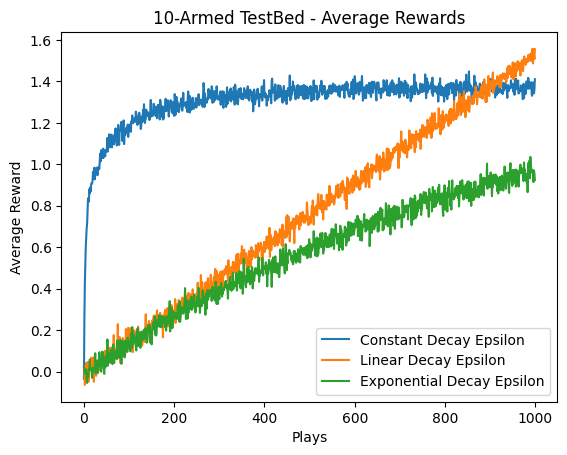

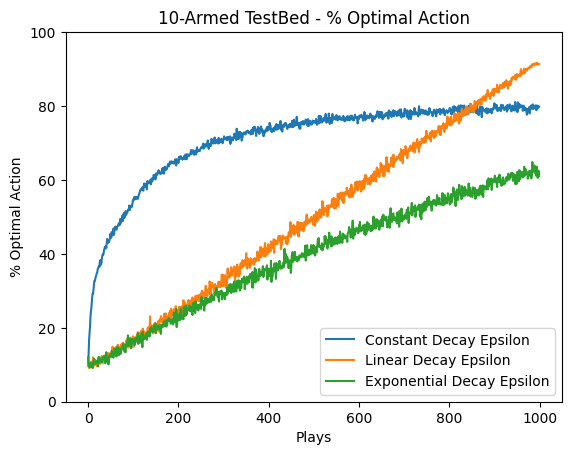

In [41]:
if __name__ == "__main__":
    start_time = time.time()
    nArms = 10
    iterations = 2000
    plays = 1000

    testbed = Testbed(nArms=nArms, mean=0, stDev=1)

    # Create agents with constant, linear, and exponential decay
    #CHECK ++++++++++++++++++++++++++++++++++++++++++++++
    agents = [
        Agent(nArms=nArms, decay_type='constant', eProb=0.1),
        Agent(nArms=nArms, decay_type='linear', initial_epsilon=1.0, final_epsilon=0.01, decay_rate=0.001),
        Agent(nArms=nArms, decay_type='exponential', initial_epsilon=1.0, final_epsilon=0.01, decay_rate=0.001)
    ]

    environment = Environment(testbed=testbed, agents=agents, plays=plays, iterations=iterations)

    print("Running...")
    g1Scores, g2Optimal = environment.play()
    print("Execution time: %s seconds" % (time.time() - start_time))

    plt.title("10-Armed TestBed - Average Rewards")
    plt.plot(g1Scores)
    plt.ylabel('Average Reward')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()

    plt.title("10-Armed TestBed - % Optimal Action")
    plt.plot(g2Optimal * 100)
    plt.ylim(0, 100)
    plt.ylabel('% Optimal Action')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()


In [32]:
import numpy as np
from tqdm import tqdm

def pure_exploitation(env, n_episodes=5000):
    # (1) Initialize the Q-function and the count array to all zeros
    Q = np.zeros((env.action_space.n,))
    N = np.zeros((env.action_space.n,))

    # (3) Variables for calculating statistics (not necessary for the strategy itself)
    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)

    # (4) Main loop: interact with the environment
    name = 'Pure exploitation'
    for e in tqdm(range(n_episodes), desc='Episodes for ' + name, leave=False):
        # (5) Select the action that maximizes the estimated Q-values
        action = np.argmax(Q)

        # (6) Pass it to the environment and receive a new reward
        _, reward, _, _ = env.step(action)

        # (6 continued) Update the counts and the Q-table
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        # (7) Update statistics for this episode
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

    # (8) Return name and statistics
    return name, returns, Qe, actions
